# CNN을 기반의 U-Net 알고리즘으로 척추 인식 및 Cobb Angle의 측정

## Loading Package

In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import glob
import matplotlib.pyplot as plt
import keras as K

## Definition Funtions & Background Setting

In [2]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

In [3]:
def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

In [4]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
  
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

In [5]:
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [6]:
def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr

In [7]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

In [8]:
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        from skimage import img_as_uint
        io.imsave(os.path.join(save_path,"%d_predict.tif"%(i)),img_as_uint(img))

## Definition U-Net Algorithm

In [9]:
def dice_score_loss(y_true, y_pred):
    numerator = 2. *tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return tf.reduce_mean(1-numerator/denominator)

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_flatten_layer = tf.keras.layers.Flatten()
    y_true_f = y_true_flatten_layer(y_true)
    y_pred_flatten_layer = tf.keras.layers.Flatten()
    y_pred_f = y_pred_flatten_layer(y_pred)
    intersection = tf.keras.layers.Dot(y_true, tf.transpose(y_pred))
    union = tf.keras.layers.Dot(y_true, tf.transpose(y_true))+tf.keras.layers.Dot(y_pred, tf.transpose(y_pred))
    return (2. * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return tf.keras.metrics.Mean(1-dice_coef(y_true, y_pred), axis=-1)

In [11]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(tf.compat.v1.train.AdamOptimizer(learning_rate=3e-5), loss = dice_score_loss, metrics = [tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Training

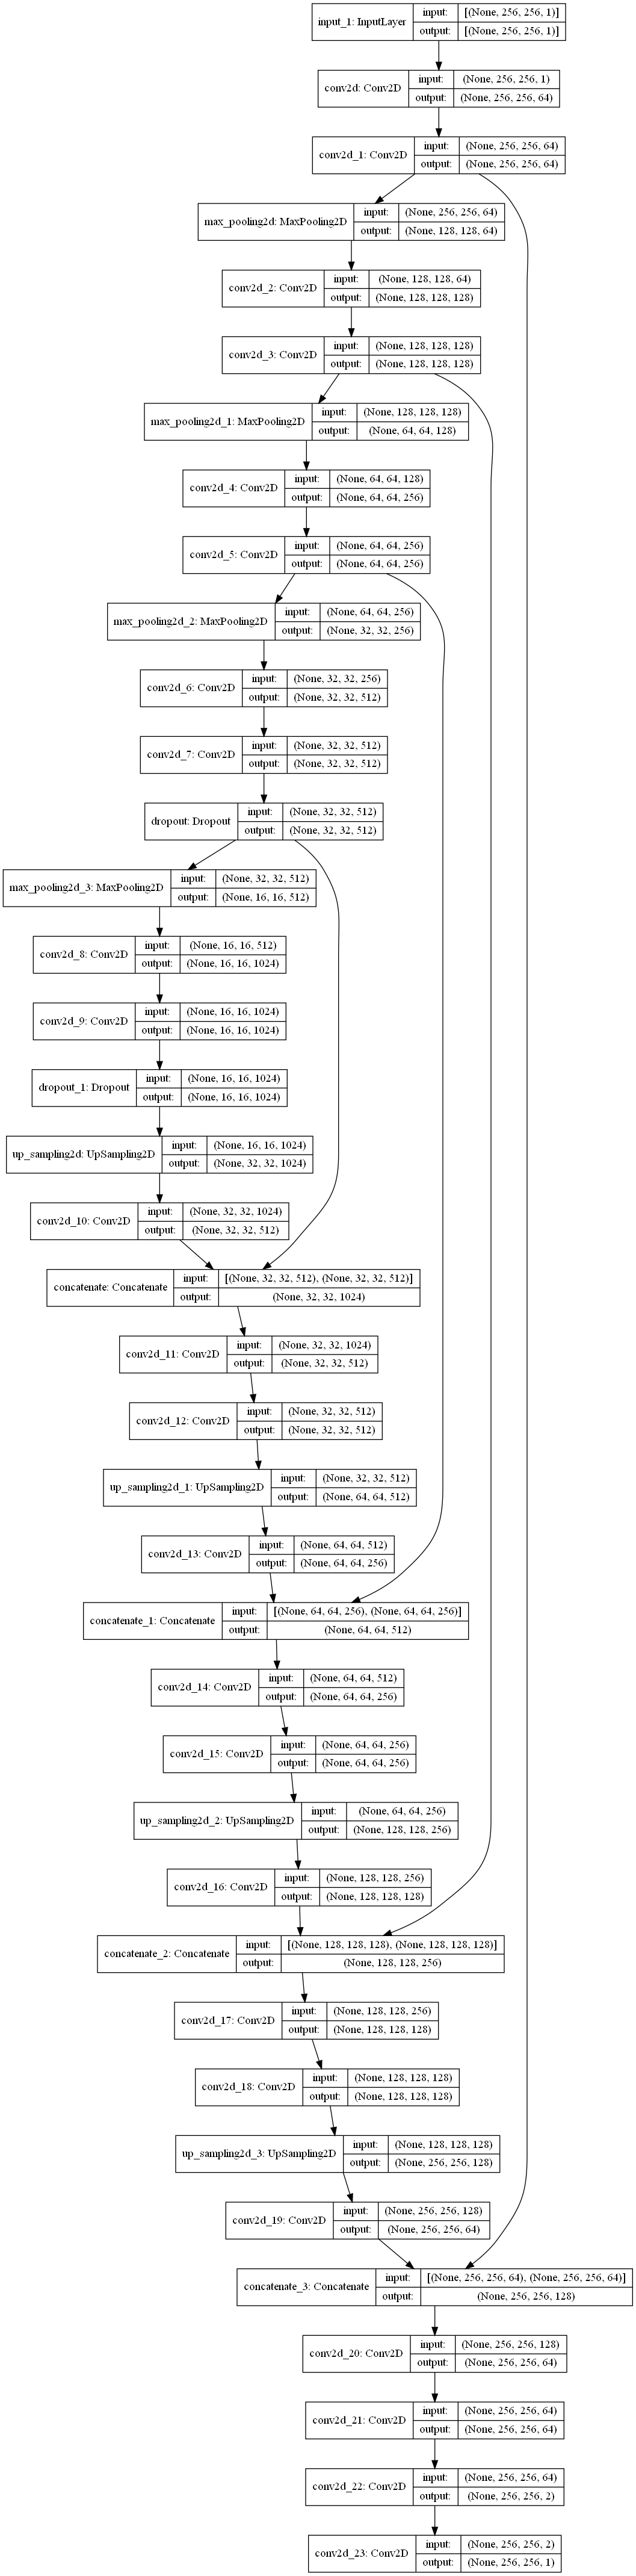

In [12]:
tf.keras.utils.plot_model(unet(), show_shapes=True)

In [13]:
data_gen_args = dict(rotation_range=0.2,width_shift_range=0.05,height_shift_range=0.05,shear_range=0.05,zoom_range=0.05,horizontal_flip=True,fill_mode='nearest')

In [14]:
myGene = trainGenerator(2,'data/train','image','label',data_gen_args,save_to_dir = "trainGene")

In [15]:
model = unet()

In [16]:
model_checkpoint = ModelCheckpoint('unet_spine.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [17]:
model_history=model.fit(myGene,steps_per_epoch=300,epochs=2, callbacks=[model_checkpoint])

Found 180 images belonging to 1 classes.
Found 180 images belonging to 1 classes.
Epoch 1/2
300/300 [==============================] - 208s 613ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.0000e+00

Epoch 00001: loss improved from inf to 1.00000, saving model to unet_spine.hdf5
Epoch 2/2
300/300 [==============================] - 187s 624ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.0000e+00

Epoch 00002: loss did not improve from 1.00000


In [18]:
testGene = testGenerator("data/test/image")

In [19]:
results = model.predict(testGene,174/4,verbose=1)

30/30 [==============================] - 33s 1s/step


In [20]:
saveResult("data/spine/test",results)

<ipython-input-8-6b972612b925>:5: UserWarning: data/spine/test\0_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.tif"%(i)),img_as_uint(img))
<ipython-input-8-6b972612b925>:5: UserWarning: data/spine/test\10_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.tif"%(i)),img_as_uint(img))
<ipython-input-8-6b972612b925>:5: UserWarning: data/spine/test\11_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.tif"%(i)),img_as_uint(img))
<ipython-input-8-6b972612b925>:5: UserWarning: data/spine/test\12_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.tif"%(i)),img_as_uint(img))
<ipython-input-8-6b972612b925>:5: UserWarning: data/spine/test\13_predict.tif is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.tif"%(i)),img_as_uint(img))
<ipython-input-8-6b972612b925>:5: UserWarning: data/spine/test\14_predict.tif is a low contrast image
  io.imsave(os